In [81]:
import igraph as ig
import matplotlib.pyplot as plt
import math
import numpy as np
import time
import torch
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import torch.nn as nn
import torch.nn.functional as F

%load_ext autoreload
%autoreload 2
import layers
import models
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Dataset loading

In [95]:
# Load data; adj includes self-edges
edges, adj, features, labels, idx_train, idx_val, idx_test = utils.load_data()

Loading cora dataset...


In [71]:
# a slow way to get degree
edges_sd = adj.coalesce().indices()
num_of_edges = edges_sd.shape[1]
print(num_of_edges)
num_of_nodes = adj.shape[0]
in_degrees = np.zeros(num_of_nodes, dtype=int)
out_degrees = np.zeros(num_of_nodes, dtype=int)
for cnt in range(num_of_edges):
    source_node_id = edges_sd[0,cnt]
    target_node_id = edges_sd[1,cnt]
    out_degrees[source_node_id] += 1  # source node points towards some other node -> increment its out degree
    in_degrees[target_node_id] += 1  # similarly here

13264


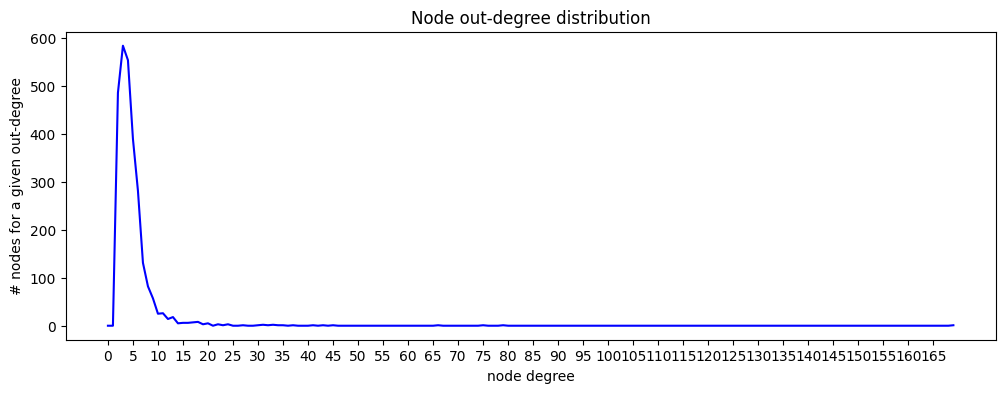

In [43]:
# make a histogram of degrees
hist = np.zeros(np.max(out_degrees) + 1)
for out_degree in out_degrees:
    hist[out_degree] += 1
fig = plt.figure(figsize=(12,4), dpi=100)
plt.plot(hist, color='blue')
plt.xlabel('node degree')
plt.ylabel('# nodes for a given out-degree') 
plt.title(f'Node out-degree distribution')
plt.xticks(np.arange(0, len(hist), 5.0))
plt.show()

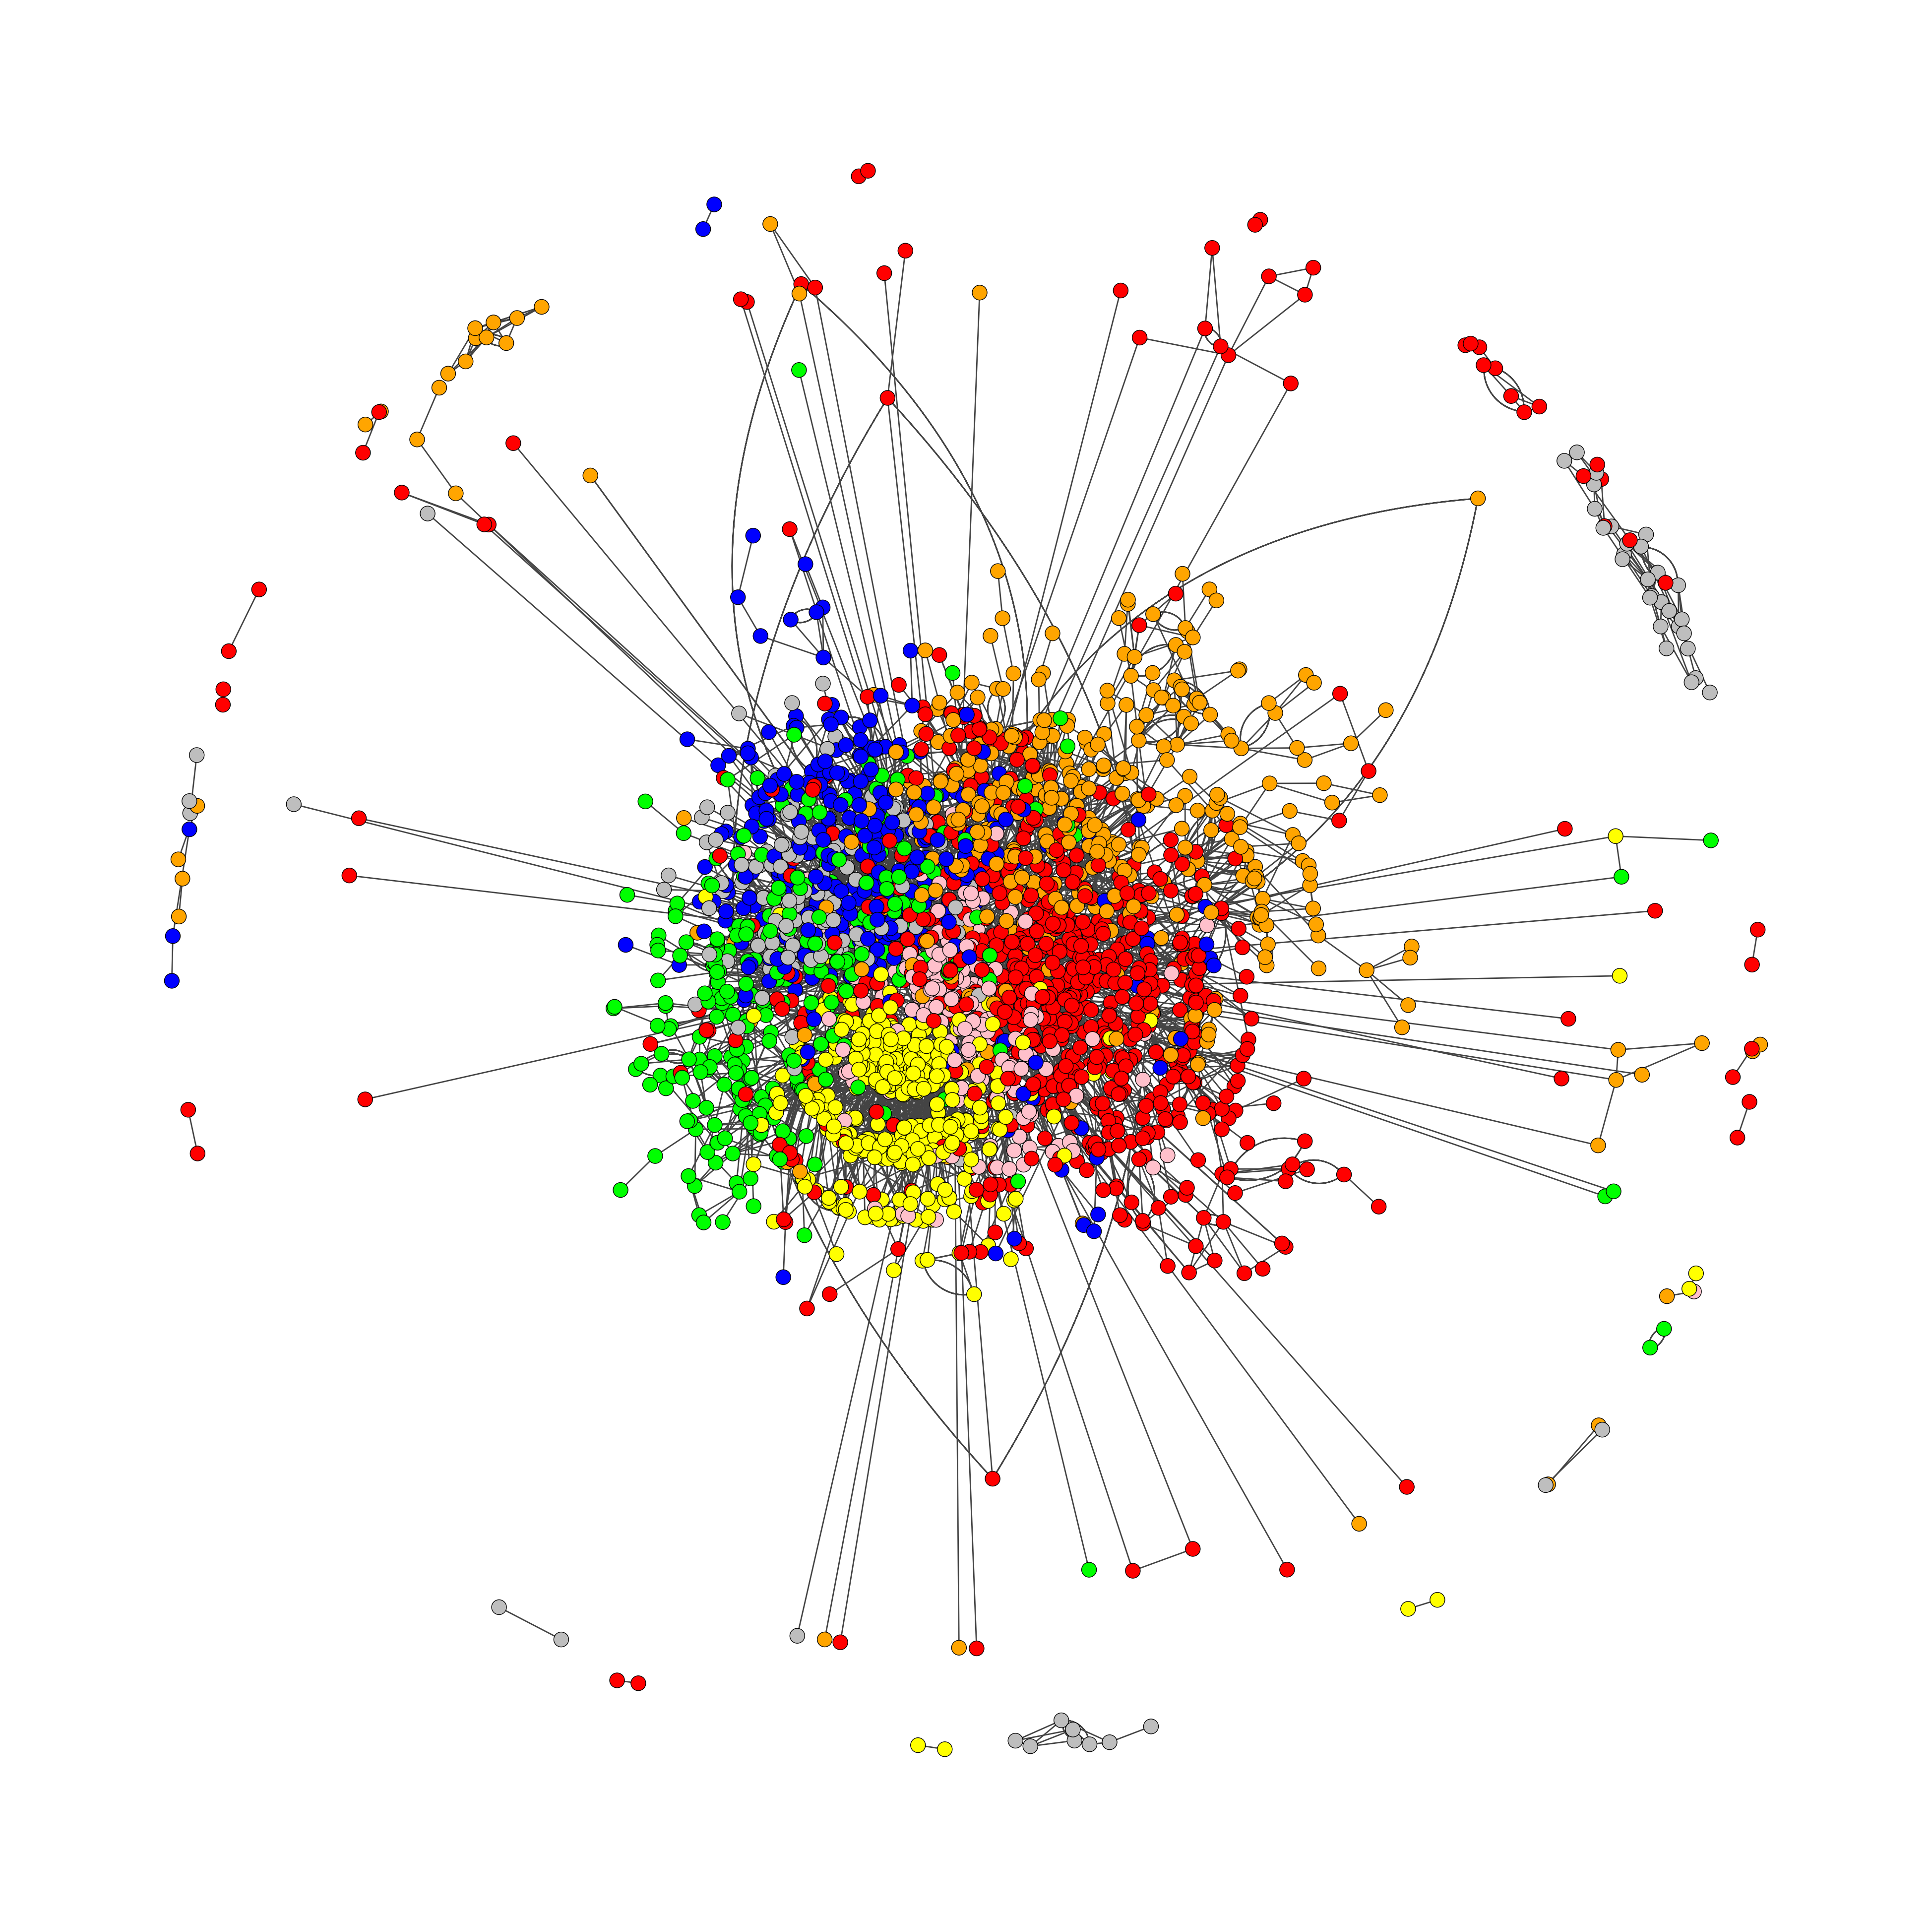

In [80]:
# Construct the igraph graph
ig_graph = ig.Graph()
ig_graph.add_vertices(labels.shape[0])
edges_ig = list(zip(edges_sd[0, :], edges_sd[1, :]))
ig_graph.add_edges(edges)
cora_label_to_color_map = {0: "red", 1: "blue", 2: "green", 3: "orange", 4: "yellow", 5: "pink", 6: "gray"}
ig_graph.vs["color"] = [cora_label_to_color_map[int(label.numpy())] for label in labels]
#ig_graph.vs["size"] = [int(deg / 4) for deg in ig_graph.degree()]
layout = ig_graph.layout_kamada_kawai()
fig, ax = plt.subplots(1, 1, figsize=(50, 50))
ig.plot(ig_graph, layout=layout, target=ax)

### Setting up the model

In [82]:
class GraphConvolution(Module):
    """
    Implementation from: https://github.com/tkipf/pygcn
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        # computes adj * input * weight + bias; assumes adj is already normalised by degree matrix
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support) # multiplies adj with support, adj is a sparse matrix
        if self.bias is not None:
            return output + self.bias
        else:
            return output

In [83]:
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()
        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nclass)
        self.dropout = dropout

    def forward(self, x, adj):
        # a two-layer GCN with a ReLU activation function and dropout and softmax
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj)
        return F.log_softmax(x, dim=1)


### The train loop

In [104]:
# Model and optimizer
hidden = 16
dropout = 0.5
lr = 0.01
weight_decay = 5e-4
use_cuda = False
fastmode = False
epochs = 300

model = GCN(nfeat=features.shape[1],
            nhid=hidden,
            nclass=labels.max().item() + 1,
            dropout=dropout)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

if use_cuda:
    model.cuda()
    features = features.cuda()
    adj = adj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_val = idx_val.cuda()
    idx_test = idx_test.cuda()

In [105]:
def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    acc_train = utils.accuracy(output[idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()

    if not fastmode:
        # Evaluate validation set performance separately,
        # deactivates dropout during validation run.
        model.eval()
        output = model(features, adj)

    # uses the nll_loss which takes the loglikelihood of the output at its true class
    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = utils.accuracy(output[idx_val], labels[idx_val])
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))

# Train model
t_total = time.time()
for epoch in range(epochs):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))


Epoch: 0001 loss_train: 2.0005 acc_train: 0.1286 loss_val: 1.9886 acc_val: 0.1267 time: 0.0082s
Epoch: 0002 loss_train: 1.9603 acc_train: 0.1214 loss_val: 1.9674 acc_val: 0.1267 time: 0.0059s
Epoch: 0003 loss_train: 1.9482 acc_train: 0.1500 loss_val: 1.9492 acc_val: 0.1267 time: 0.0055s
Epoch: 0004 loss_train: 1.9160 acc_train: 0.1500 loss_val: 1.9331 acc_val: 0.1267 time: 0.0057s
Epoch: 0005 loss_train: 1.9065 acc_train: 0.1786 loss_val: 1.9181 acc_val: 0.1333 time: 0.0058s
Epoch: 0006 loss_train: 1.8982 acc_train: 0.2000 loss_val: 1.9039 acc_val: 0.2267 time: 0.0054s
Epoch: 0007 loss_train: 1.8843 acc_train: 0.2643 loss_val: 1.8906 acc_val: 0.2033 time: 0.0051s
Epoch: 0008 loss_train: 1.8744 acc_train: 0.2286 loss_val: 1.8780 acc_val: 0.1600 time: 0.0054s
Epoch: 0009 loss_train: 1.8378 acc_train: 0.3214 loss_val: 1.8661 acc_val: 0.1700 time: 0.0052s
Epoch: 0010 loss_train: 1.8321 acc_train: 0.2929 loss_val: 1.8547 acc_val: 0.1733 time: 0.0050s
Epoch: 0011 loss_train: 1.8307 acc_train

### Present the results

In [106]:
def test():
    # add a hook to extract hidden layer output 
    activations = []
    def hook_fn(module, input, output):
        activations.append(output)
    h = model.gc1.register_forward_hook(hook_fn)
    model.eval()
    output = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = utils.accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))
    h.remove()
    return output, activations

# Testing
output, activations = test()
# activations is of shape [2708, 16]


Test set results: loss= 0.6436 accuracy= 0.8370


In [107]:
# Let's print a few predictions 
print(output[:10].argmax(dim=1))

tensor([0, 6, 5, 5, 3, 3, 1, 0, 0, 1])


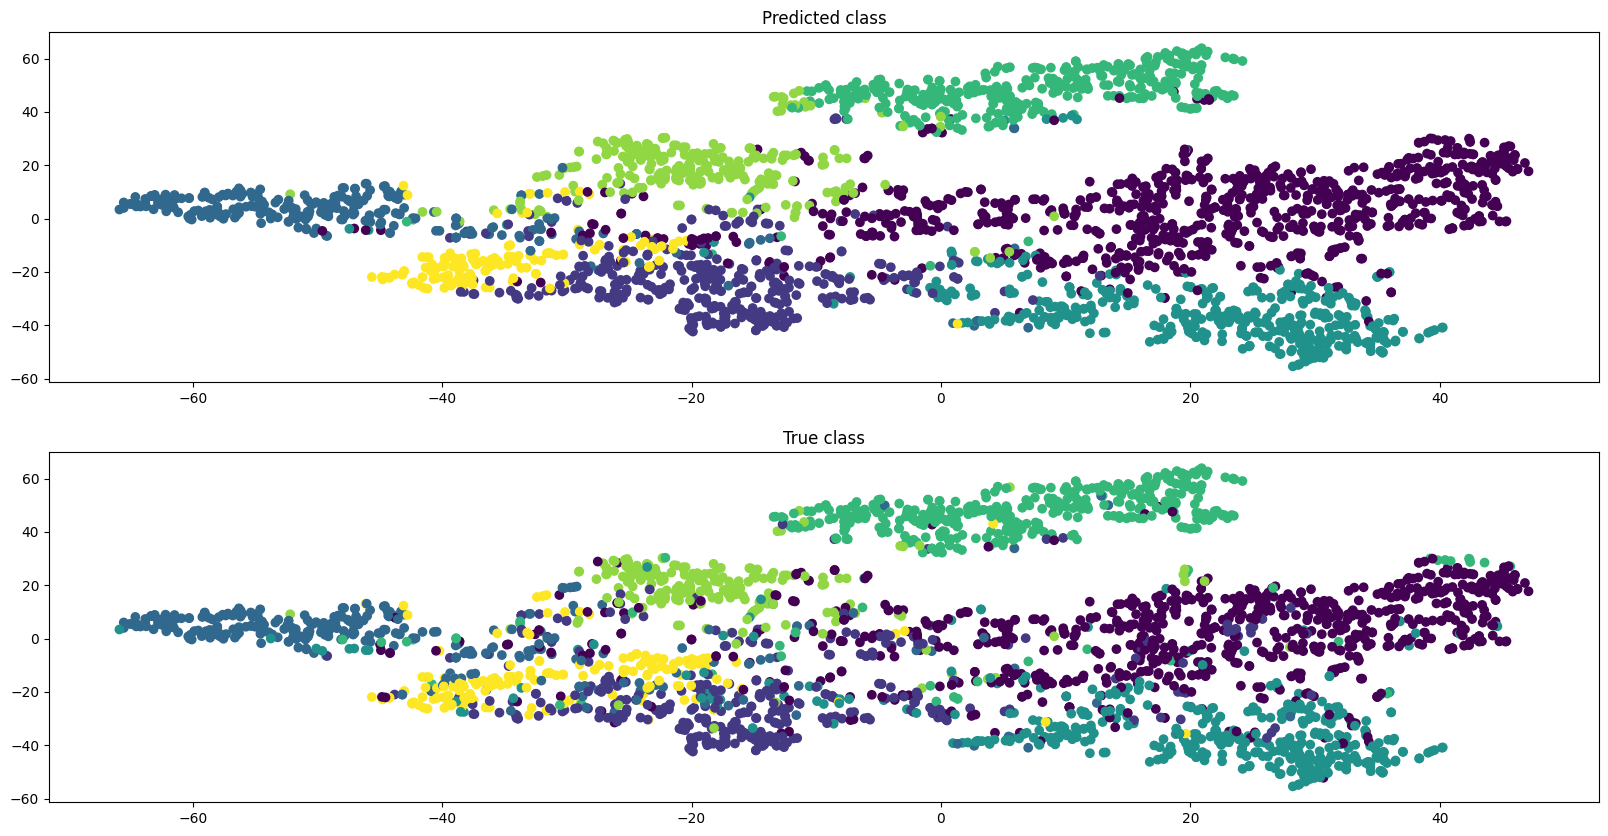

In [108]:
# plot the tsne embeddings of the hidden state activations colored by the predicted class
from sklearn.manifold import TSNE
import numpy as np

activations_np = activations[0].detach().cpu().numpy()
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(activations_np)
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].scatter(tsne_result[:,0], tsne_result[:,1], c=output.argmax(dim=1).detach().cpu().numpy())
ax[0].set_title('Predicted class')
ax[1].scatter(tsne_result[:,0], tsne_result[:,1], c=labels.cpu().numpy())
ax[1].set_title('True class')
plt.show()